In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/google-playstore-apps/Google Playstore Apps.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid") # Configure seaborn for better visuals

In [3]:
import os

print(os.listdir("/kaggle/input/google-playstore-apps"))


['Google Playstore Apps.csv']


In [4]:
df = pd.read_csv('/kaggle/input/google-playstore-apps/Google Playstore Apps.csv')

# Quick check of the dataset shape and first rows
print(df.shape)
df.head()


(9745, 12)


,Unnamed: 0,App,Category,Rating,Reviews,Installs,Type,Price,Genres,Last Updated,Current Ver,Android Ver
0,0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,10000,Free,0.0,Art & Design,2018-01-07,1.0.0,4.0.3 and up
1,1,Coloring book moana,ART_AND_DESIGN,3.9,967,500000,Free,0.0,Art & Design;Pretend Play,2018-01-15,2.0.0,4.0.3 and up
2,2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,5000000,Free,0.0,Art & Design,2018-08-01,1.2.4,4.0.3 and up
3,3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,50000000,Free,0.0,Art & Design,2018-06-08,Varies with device,4.2 and up
4,4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,100000,Free,0.0,Art & Design;Creativity,2018-06-20,1.1,4.4 and up


In [5]:
# (A) Remove duplicates
df.drop_duplicates(inplace=True)

# (B) Drop irrelevant columns (only if they exist)
cols_to_drop = ['Last Updated', 'Current Ver', 'Android Ver']
df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)

# (C) Clean Installs column
if 'Installs' in df.columns:
    df['Installs'] = df['Installs'].astype(str) \
                                   .str.replace('+', '', regex=False) \
                                   .str.replace(',', '', regex=False) \
                                   .str.strip()
    df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')
else:
    raise KeyError("Column 'Installs' not found. Check df.columns to confirm the exact name.")

# (D) Clean Reviews column (convert to numbers)
if 'Reviews' in df.columns:
    df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')
else:
    raise KeyError("Column 'Reviews' not found. Check df.columns to confirm the exact name.")

# (E) Clean Price column
if 'Price' in df.columns:
    df['Price'] = df['Price'].astype(str).str.replace('$', '', regex=False).str.strip()
    df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# (F) Handle missing values in the key columns you care about (Only keep rows that have these four basics.)
required = [c for c in ['Installs', 'Reviews', 'Category', 'Rating'] if c in df.columns]
if set(['Installs', 'Reviews', 'Category', 'Rating']).issubset(df.columns):
    df = df.dropna(subset=required)
else:
    missing = set(['Installs', 'Reviews', 'Category', 'Rating']) - set(df.columns)
    raise KeyError(f"Missing expected column(s): {missing}. Check df.columns.")


In [6]:
# checking for cleaning 
print(df[['Installs','Reviews','Price','Rating']].dtypes)
print(df[['Installs','Reviews','Price','Rating']].isna().sum())
print(df.shape)


Installs      int64
Reviews       int64
Price       float64
Rating      float64
dtype: object
Installs    0
Reviews     0
Price       0
Rating      0
dtype: int64
(8281, 9)


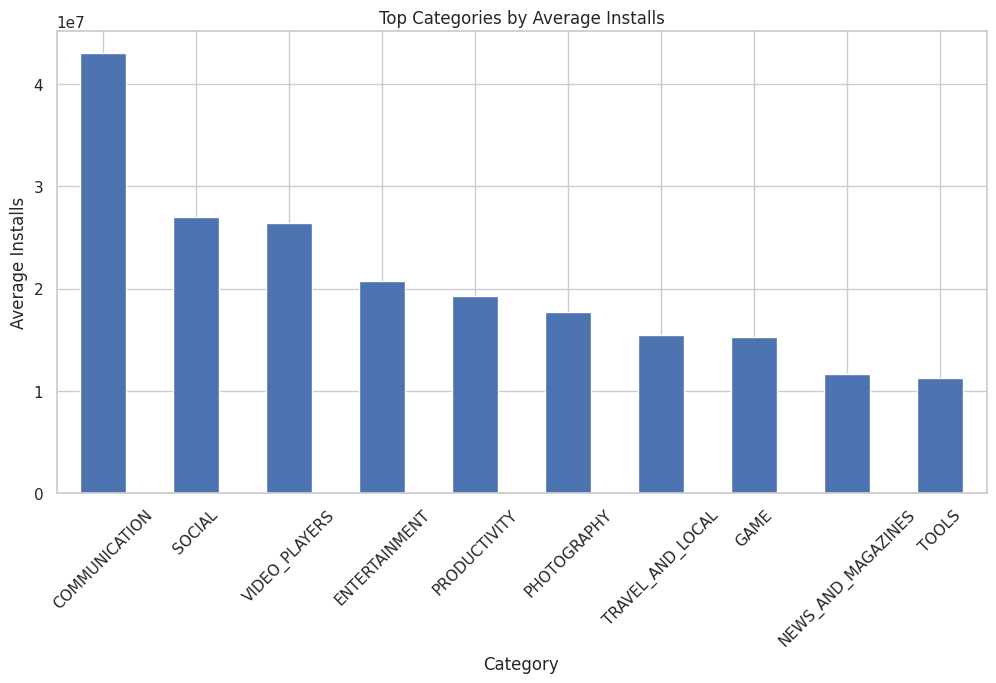

In [7]:
# Top Categories by Average Installs
# Question: Which app categories attract the most installs on average?

if {'Category','Installs'}.issubset(df.columns):
    top_categories = (
        df.groupby('Category')['Installs']
          .mean()
          .sort_values(ascending=False)
          .head(10)
    )

    plt.figure(figsize=(12,6))
    top_categories.plot(kind='bar')
    plt.title('Top Categories by Average Installs')
    plt.ylabel('Average Installs')
    plt.xlabel('Category')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("Missing 'Category' or 'Installs' column, skipping this chart.")


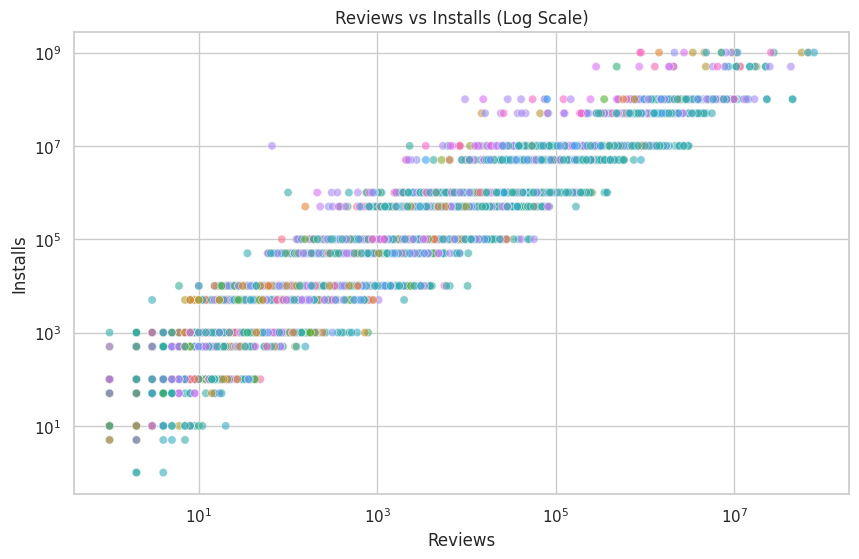

In [8]:
# Reviews vs Installs
# Question: Do apps with more reviews also have more installs?
# Reviews are a proxy for user engagement.

if {'Reviews','Installs'}.issubset(df.columns):
    plt.figure(figsize=(10,6))
    sns.scatterplot(
        x='Reviews', 
        y='Installs', 
        hue='Category' if 'Category' in df.columns else None,
        data=df, 
        alpha=0.6, 
        legend=False
    )
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Reviews vs Installs (Log Scale)')
    plt.xlabel('Reviews')
    plt.ylabel('Installs')
    plt.show()
else:
    print("Missing 'Reviews' or 'Installs' column, skipping scatter plot.")


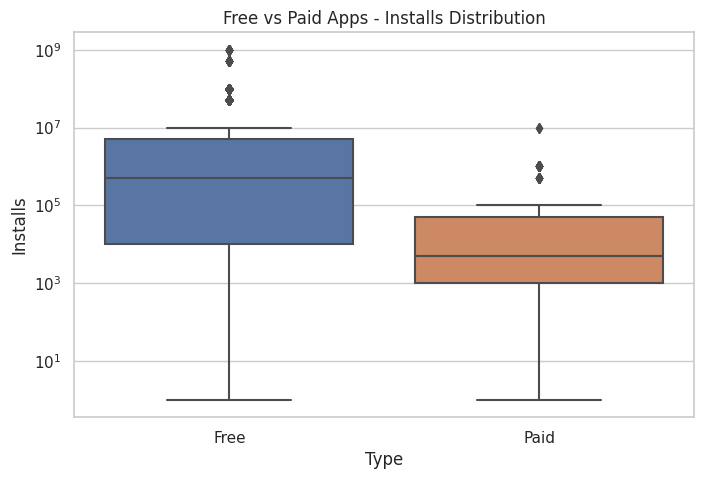

In [9]:
# Free vs Paid Apps
# Question: Do free apps really get more installs than paid apps?

if {'Type','Installs'}.issubset(df.columns):
    plt.figure(figsize=(8,5))
    sns.boxplot(x='Type', y='Installs', data=df)
    plt.yscale('log')
    plt.title('Free vs Paid Apps - Installs Distribution')
    plt.show()
else:
    print("Missing 'Type' or 'Installs' column, skipping boxplot.")


In [10]:
# Insights & Recommendations
print("\nKey Insights:")

if 'Category' in df.columns and 'Installs' in df.columns:
    top_categories = (
        df.groupby('Category')['Installs']
          .mean()
          .sort_values(ascending=False)
          .head(10)
    )
    print("1. Categories with highest installs include:", list(top_categories.index))
else:
    print("1. Could not calculate top categories (missing data).")

if {'Type','Installs'}.issubset(df.columns):
    print("2. Free apps generally attract significantly more installs compared to paid apps.")
else:
    print("2. Could not compare Free vs Paid (missing 'Type').")

if {'Reviews','Installs'}.issubset(df.columns):
    print("3. Apps with higher reviews usually correlate with higher installs (user engagement).")
else:
    print("3. Could not analyze reviews vs installs.")

print("\nRecommendations:")
if 'Category' in df.columns and 'Installs' in df.columns:
    print("- Focus on high-install categories such as {}."
          .format(', '.join(top_categories.index[:3])))
print("- Prioritize free apps to maximize reach and ad revenue potential.")
print("- Encourage user reviews/ratings to build trust and attract more downloads.")



Key Insights:
1. Categories with highest installs include: ['COMMUNICATION', 'SOCIAL', 'VIDEO_PLAYERS', 'ENTERTAINMENT', 'PRODUCTIVITY', 'PHOTOGRAPHY', 'TRAVEL_AND_LOCAL', 'GAME', 'NEWS_AND_MAGAZINES', 'TOOLS']
2. Free apps generally attract significantly more installs compared to paid apps.
3. Apps with higher reviews usually correlate with higher installs (user engagement).

Recommendations:
- Focus on high-install categories such as COMMUNICATION, SOCIAL, VIDEO_PLAYERS.
- Prioritize free apps to maximize reach and ad revenue potential.
- Encourage user reviews/ratings to build trust and attract more downloads.


In [11]:
print(df.columns.tolist())


['Unnamed: 0', 'App', 'Category', 'Rating', 'Reviews', 'Installs', 'Type', 'Price', 'Genres']
